In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import os
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# import sys
# # sys.path.append('/home/chenjn/rna2adt')
# sys.path.append('./')

In [2]:
import numpy as np
from tqdm import tqdm
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import fowlkes_mallows_score as FMI
from sklearn.metrics import silhouette_score as SC
import dataset
import dataloaders
import scanpy as sc
import scbasset_ori as scbasset
import sklearn
from utils import get_R
from biock import make_directory, make_logger, get_run_info
from biock.pytorch import model_summary, set_seed
from biock import HG19_FASTA_H5, HG38_FASTA_H5

from torch.utils.tensorboard import SummaryWriter

from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from utils import find_res_label

No module named 'pyfaidx'


In [3]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    assert y_pred.size == y_true.size
    
    encoder = LabelEncoder()
    encoder = encoder.fit(np.unique(y_true))
    y_true = encoder.transform(y_true).astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # ind = linear_assignment(w.max() - w)
    ind = linear_sum_assignment(w.max() - w)
    ind = np.array((ind[0], ind[1])).T

    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
def label_scores(embeddings, labels):
    nn_ = NearestNeighbors(n_neighbors=20)
    nn_.fit(embeddings)
    knns = nn_.kneighbors(embeddings, return_distance=False)

    res = 0
    for i in range(len(embeddings)):
        num = 0
        for j in range(len(knns[i])):
            if labels[i] == labels[knns[i][j]]:
                num += 1
        res += num / len(knns[i])

    return res / len(embeddings)

In [5]:
def test_model(model, loader, device, epoch):
    model.eval()
    all_label = list()
    all_pred = list()

    for it, (seq, adt) in enumerate(tqdm(loader)):
        seq = seq.to(device)
        output = model(seq)[0].detach()
        output = torch.sigmoid(output).cpu().numpy().astype(np.float16)

        adt = adt.numpy().astype(np.float16)

        all_pred.append(output)
        all_label.append(adt)

    all_pred = np.concatenate(all_pred, axis=0)
    all_label = np.concatenate(all_label, axis=0)

    R = get_R(all_pred, all_label, dim=0)[0]
    R1 = get_R(all_pred, all_label, dim=1)[0]

    R = np.nanmean(R)
    R1 = np.nanmean(R1)

    embedding = model.get_embedding().detach().cpu().numpy().astype(np.float32)

    adata1 = sc.AnnData(
        embedding,
        obs=adtT.obs,
    )
    sc.pp.neighbors(adata1, use_rep='X')
    sc.tl.umap(adata1)

    sc.tl.louvain(adata1)
    adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))

    ari = ARI(adata1.obs['louvain'], adata1.obs[label_key])
    nmi = NMI(adata1.obs['louvain'], adata1.obs[label_key])
    ca = cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain'].values.to_numpy())
    fmi = FMI(adata1.obs['louvain'], adata1.obs[label_key])
    sci = SC(adata1.X, adata1.obs['louvain'].values.reshape(-1, 1))
    lsi = label_scores(embedding, adata1.obs[label_key])

    ari_res = ARI(adata1.obs['louvain_res'], adata1.obs[label_key])
    nmi_res = NMI(adata1.obs['louvain_res'], adata1.obs[label_key])
    ca_res = cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain_res'].values.to_numpy())
    fmi_res = FMI(adata1.obs['louvain_res'], adata1.obs[label_key])
    sci_res = SC(adata1.X, adata1.obs['louvain_res'].values.reshape(-1, 1))

    if epoch is not None:
        print('ARI: ' + str(ari) + ', NMI: ' + str(nmi) + ', CA: ' + str(ca) + ', FMI', str(fmi) + ', SCI', str(sci) + ', LSI', str(lsi))
        print('ARI: ' + str(ari_res) + ', NMI: ' + str(nmi_res) + ', CA: ' + str(ca_res) + ', FMI', str(fmi_res) + ', SCI', str(sci_res))

        # writer.add_scalar('ARI', ari, global_step=epoch)
        # writer.add_scalar('NMI', nmi, global_step=epoch)
        # writer.add_scalar('CA', ca, global_step=epoch)
        # writer.add_scalar('FMI', fmi, global_step=epoch)
        # writer.add_scalar('SC', sci, global_step=epoch)
        # writer.add_scalar('PCC0', R, global_step=epoch)
        # writer.add_scalar('PCC1', R1, global_step=epoch)

    return R, R1, sci, sci_res, embedding

In [6]:
def split_dataset(length, tr, va):
    seq = np.random.permutation(np.arange(length))
    trs = seq[:int(length * tr)]
    vas = seq[int(length * tr) : int(length * (tr + va))]
    tes = seq[int(length * (tr + va)):]

    return trs, vas, tes

## Haperparameters

In [7]:
seq_len = 1344
batch_size = 4
num_workers = 2
z_dim = 256 
lr = 0.01
max_epoch = 500
batch=None
seed = 3407

In [8]:
set_seed(seed, force_deterministic=True)

In [9]:
outdir = make_directory('./output')
# logger = make_logger(title="", filename=os.path.join(outdir, "train.log"))

## Load data

In [10]:
data = 'reap2'

In [11]:
if data in ['pbmc']:
    rna_data = './data/' + data + '/RNA.h5ad'
    adt_data = './data/' + data + '/ADT.h5ad'
    ref_data = './data/' + data + '/CCND.csv'
    label_key = 'celltype.l2'
elif 'reap' in data:
    adt_data = './data/' + data + '/ADT.h5ad'
    ref_data = './data/pbmc/CCND.csv'
    label_key = 'labels'
elif 'sln' in data:
    adt_data = './data/' + data + '/ADT.h5ad'
    ref_data = './data/pbmc/CCND.csv'
    label_key = 'cell_types'
else:
    # logger.info('Not implemented!!!')
    print('Not implemented!!!')

In [13]:
adtT = dataset.SingleCellDataset(
    data=dataset.load_adata(adt_data, log1p=True, nor=True), 
    seq_ref=dataset.load_csv(ref_data),
    seq_len=seq_len, 
    batch=batch,
)

## Visualization of raw data

In [14]:
adata = sc.AnnData(
    adtT.X.T,
    obs=adtT.obs,
)
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)

In [15]:
sc.tl.louvain(adata, random_state=seed)

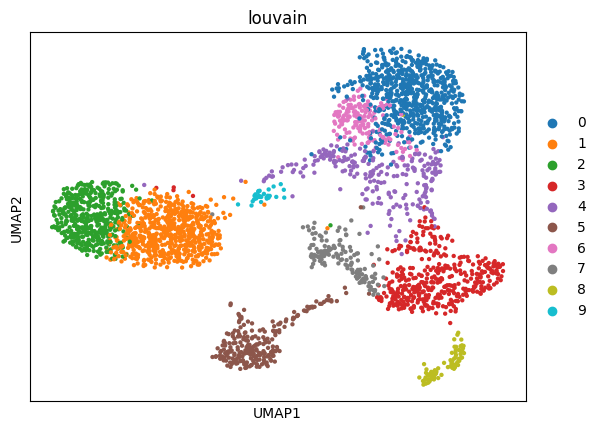

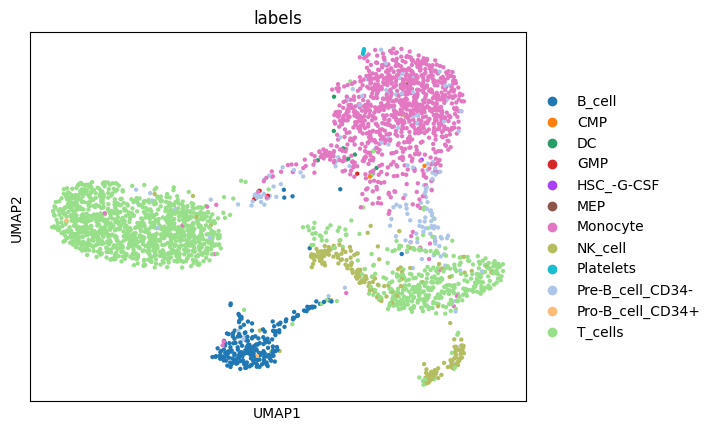

In [16]:
sc.pl.umap(adata, color='louvain')
sc.pl.umap(adata, color=label_key)

In [17]:
print(ARI(adata.obs['louvain'], adata.obs[label_key]))
print(NMI(adata.obs['louvain'], adata.obs[label_key]))
print(cluster_acc(adata.obs[label_key].to_numpy(), adata.obs['louvain'].values.to_numpy()))
print(FMI(adata.obs['louvain'], adata.obs[label_key]))
# print(SC(adata.X, adata.obs['louvain'].values.reshape(-1, 1)))

0.3984529586419465
0.5560514799004957
0.5323107049608355
0.5708344452920326


## Construct train and test set

In [18]:
train_loader = DataLoader(
    adtT,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=4
)

In [19]:
sampled = np.random.permutation(np.arange(len(adtT)))[:10]
valid_loader = DataLoader(
    Subset(adtT, sampled),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

## Train the model

In [20]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
model = scbasset.scBasset(n_cells=adtT.X.shape[1], hidden_size=z_dim, seq_len=seq_len, batch_ids=adtT.batche_ids).to(device)

In [22]:
load = 0

# 100
if not load:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode="max",
        factor=0.95,
        patience=2,
        min_lr=1e-7
    )

    best_score = 0
    wait = 0
    patience = 15

    best_sci = 0
    best_embedding = None

    max_epoch = max_epoch
    for epoch in range(max_epoch):
        pool = [np.nan for _ in range(10)]
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}")
        model.train()
        for it, (seq, adt) in enumerate(pbar):
            seq, adt = seq.to(device), adt.to(device)
            # print(it,seq.shape,adt.shape);print()

            optimizer.zero_grad()
            with autocast():
                output = model(seq)[0]
                # print(output.shape, adt.shape)
                loss = criterion(output, adt)
                # print(loss)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            pool[it % 10] = loss.item()

            lr = optimizer.param_groups[-1]["lr"]
            pbar.set_postfix_str(f"loss/lr={np.nanmean(pool):.4f}/{lr:.3e}")
            # break
        
        
        if epoch % 10 == 0: 
            pcc0, pcc1, sci, sci_res, embedding = test_model(model, valid_loader, device, epoch)
            # pcc0, pcc1, sci, sci_res, embedding = test_model(model, train_loader, device, epoch)
            
            if sci > best_sci:
                best_sci = sci
                best_embedding = embedding

        #     logger.info("Validation{} PCC0={:.4f} PCC1={:.4f} SC={:.4f}".format((epoch + 1), pcc0, pcc1, sci))

            # val_score = sci

            # # scheduler.step(val_score)

            # if val_score > best_score:
            #     best_score = val_score
            #     wait = 0
            #     torch.save(model.state_dict(), "{}/best_scb_ori_{}_{}_{}_{}_{}_{}.pt".format(outdir, str(batch), str(seq_len), str(z_dim), str(lr * 1000), str(device), str(seed)))
            #     logger.info(f"Epoch {epoch+1}: best model saved\n")
            # else:
            #     wait += 1
            #     if wait <= patience / 2:
            #         embedding = model.get_embedding().detach().cpu().numpy().astype(np.float32)
            #         sc.AnnData(embedding, obs=adtT.obs).write_h5ad("{}/best_scb_ori_emb_{}_{}_{}_{}_{}_{}.h5ad".format(outdir, str(batch), str(seq_len), str(z_dim), str(lr * 1000), str(device), str(seed)))

            #         logger.info(f"Epoch {epoch+1}: early stopping patience {wait}/{patience}, embedding saved\n")
            #     else:
            #         logger.info(f"Epoch {epoch+1}: early stopping patience {wait}/{patience}\n")
            #     if wait >= patience:
            #         logger.info(f"Epoch {epoch+1}: early stopping")
            #         break

Epoch 1/500:   0%|                                                                                                                                                                                                    | 0/12 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.57it/s]


ARI: 0.14734524396904622, NMI: 0.18018579798333667, CA: 0.3518276762402089, FMI 0.360227951567861, SCI 0.023028601, LSI 0.6594647519582275
ARI: 0.12361061527419256, NMI: 0.2160821040463336, CA: 0.264686684073107, FMI 0.3095633770284662, SCI 0.012315599


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.27it/s]


ARI: 0.37371969791605864, NMI: 0.5231353093187692, CA: 0.46279373368146215, FMI 0.5491941361717798, SCI 0.057108328, LSI 0.8466057441253261
ARI: 0.25307839787415715, NMI: 0.45451181394682894, CA: 0.3456266318537859, FMI 0.4419020958657482, SCI 0.040053666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.95it/s]


ARI: 0.3715303447679375, NMI: 0.5233045232728956, CA: 0.4640992167101828, FMI 0.5473593546466962, SCI 0.06923046, LSI 0.8556462140992164
ARI: 0.28461420542011545, NMI: 0.48175510702367896, CA: 0.375, FMI 0.4724236866715436, SCI 0.042391676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.71it/s]


ARI: 0.4645797166494693, NMI: 0.5558345344262088, CA: 0.5822454308093995, FMI 0.622899614561408, SCI 0.07979939, LSI 0.8615208877284605
ARI: 0.25736477321179313, NMI: 0.4661023246572172, CA: 0.38283289817232374, FMI 0.44663495205302356, SCI 0.04325893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.37it/s]


ARI: 0.4816698247526994, NMI: 0.5609597564247855, CA: 0.6077023498694517, FMI 0.6362026927912857, SCI 0.12269688, LSI 0.8664327676240209
ARI: 0.34055378268356384, NMI: 0.5160022449403168, CA: 0.43113577023498695, FMI 0.5229710840713719, SCI 0.054007955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.31it/s]


ARI: 0.4240479590234182, NMI: 0.5505158838693985, CA: 0.5535248041775457, FMI 0.5907348369780067, SCI 0.121116936, LSI 0.8703002610966057
ARI: 0.33130581525891395, NMI: 0.5159147481788453, CA: 0.42689295039164493, FMI 0.5142948149323738, SCI 0.08644654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.41it/s]


ARI: 0.4344649849051679, NMI: 0.5679603525339153, CA: 0.5486292428198434, FMI 0.5993009536708499, SCI 0.1314834, LSI 0.8724053524804181
ARI: 0.2616267688556944, NMI: 0.495662560608758, CA: 0.3619451697127937, FMI 0.45074555387822257, SCI 0.08135421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.90it/s]


ARI: 0.4481446224329862, NMI: 0.5706266379211806, CA: 0.5737597911227154, FMI 0.6101509871127807, SCI 0.14596967, LSI 0.8747715404699739
ARI: 0.35078755135447137, NMI: 0.5251357638432579, CA: 0.4575718015665796, FMI 0.5311350716208026, SCI 0.107863344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.86it/s]


ARI: 0.45571885615917407, NMI: 0.5638571369617379, CA: 0.5704960835509139, FMI 0.6161209319413817, SCI 0.13867627, LSI 0.8762728459530011
ARI: 0.31927894585113914, NMI: 0.5067454789080973, CA: 0.45071801566579633, FMI 0.5029775881389837, SCI 0.11041562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.57it/s]


ARI: 0.3998701288380877, NMI: 0.5540804942492686, CA: 0.5052219321148825, FMI 0.5712682931647362, SCI 0.14877905, LSI 0.8777741514360327
ARI: 0.30480868036279923, NMI: 0.511175564565651, CA: 0.4324412532637076, FMI 0.49117231360798175, SCI 0.116633326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.17it/s]


ARI: 0.3969882301432207, NMI: 0.5464441388699814, CA: 0.5078328981723238, FMI 0.5691937420564985, SCI 0.14479946, LSI 0.8794549608355108
ARI: 0.3325460610603052, NMI: 0.5232273190902643, CA: 0.4363577023498694, FMI 0.5161220858698735, SCI 0.11758716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.47it/s]


ARI: 0.41100343025944397, NMI: 0.5642462887839397, CA: 0.5241514360313316, FMI 0.5804638140189353, SCI 0.17213577, LSI 0.8810541775456913
ARI: 0.3324795781167313, NMI: 0.5107307734724259, CA: 0.4314621409921671, FMI 0.5156107712262933, SCI 0.12567098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.13it/s]


ARI: 0.41009329764678076, NMI: 0.5674173978243567, CA: 0.5290469973890339, FMI 0.5795796645275386, SCI 0.17337751, LSI 0.8822454308093984
ARI: 0.3747925892359762, NMI: 0.543239294201422, CA: 0.5075065274151436, FMI 0.5521327168051383, SCI 0.12118198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.31it/s]


ARI: 0.40530992170183483, NMI: 0.5604979193243149, CA: 0.5326370757180157, FMI 0.5763576166406926, SCI 0.14926127, LSI 0.8823759791122706
ARI: 0.3512874841389439, NMI: 0.5265060047603944, CA: 0.46344647519582244, FMI 0.5327473707995051, SCI 0.12959167


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.96it/s]


ARI: 0.3983931491924971, NMI: 0.5548841511454228, CA: 0.4980417754569191, FMI 0.5704153868619252, SCI 0.1507111, LSI 0.8825391644908602
ARI: 0.33412612225779914, NMI: 0.5265689962742258, CA: 0.41024804177545693, FMI 0.518010140278252, SCI 0.12864153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.84it/s]


ARI: 0.41672990488095546, NMI: 0.5661565601383, CA: 0.5365535248041775, FMI 0.5849453748905279, SCI 0.18000029, LSI 0.8834530026109658
ARI: 0.3402238580593841, NMI: 0.5334406231777125, CA: 0.418733681462141, FMI 0.523463250701566, SCI 0.12801895


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.85it/s]


ARI: 0.3910098115369831, NMI: 0.5558758969609735, CA: 0.4810704960835509, FMI 0.5648262068105956, SCI 0.16982965, LSI 0.8822943864229762
ARI: 0.32807334156102363, NMI: 0.5250939059785622, CA: 0.4030678851174935, FMI 0.5126184441864666, SCI 0.12895177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.72it/s]


ARI: 0.38622826332793264, NMI: 0.5506295530717132, CA: 0.49445169712793735, FMI 0.5608057677925132, SCI 0.16728258, LSI 0.8825554830287208
ARI: 0.36906096895906504, NMI: 0.5386071051012671, CA: 0.4934725848563969, FMI 0.5481010865350646, SCI 0.11866507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.90it/s]


ARI: 0.40398492671343794, NMI: 0.5618356732004048, CA: 0.5176240208877284, FMI 0.574785002899445, SCI 0.18255863, LSI 0.8825881201044373
ARI: 0.3321992171834381, NMI: 0.523559462781862, CA: 0.43505221932114885, FMI 0.5163672917800546, SCI 0.10759488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.91it/s]


ARI: 0.4015543913586647, NMI: 0.5615220046815298, CA: 0.5048955613577023, FMI 0.5735626767071901, SCI 0.1712437, LSI 0.882898172323759
ARI: 0.3329530695646657, NMI: 0.5260209284716715, CA: 0.4343994778067885, FMI 0.5168796877293484, SCI 0.14894412


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.21it/s]


ARI: 0.40758075443473923, NMI: 0.568448698751863, CA: 0.5202349869451697, FMI 0.578967445934241, SCI 0.16172707, LSI 0.8829960835509125
ARI: 0.3478340504517736, NMI: 0.5395580023214279, CA: 0.4281984334203655, FMI 0.5299727592506632, SCI 0.14024505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.15it/s]


ARI: 0.4259784065835801, NMI: 0.5683944919832986, CA: 0.5381853785900783, FMI 0.5929063312219466, SCI 0.18587394, LSI 0.8837467362924265
ARI: 0.3311551037404294, NMI: 0.526533569240992, CA: 0.4109007832898172, FMI 0.5153959397025542, SCI 0.14307287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.28it/s]


ARI: 0.40571573311097625, NMI: 0.5642593059658989, CA: 0.5244778067885117, FMI 0.5762406218778562, SCI 0.18441488, LSI 0.883485639686683
ARI: 0.3374649676270732, NMI: 0.5287222169600541, CA: 0.4383159268929504, FMI 0.5208055389546762, SCI 0.14876768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.96it/s]


ARI: 0.402632502942493, NMI: 0.5620980465232517, CA: 0.5257832898172323, FMI 0.5747121578213346, SCI 0.17437796, LSI 0.8834856396866848
ARI: 0.36670284133518366, NMI: 0.5402801278792708, CA: 0.48890339425587465, FMI 0.5456573513320113, SCI 0.13009009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.74it/s]


ARI: 0.40590161589258117, NMI: 0.5590633827660592, CA: 0.5404699738903395, FMI 0.5772499000668148, SCI 0.17379089, LSI 0.8839915143603118
ARI: 0.3344305380097748, NMI: 0.530835880961068, CA: 0.4383159268929504, FMI 0.5185396764257013, SCI 0.10874398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.95it/s]


ARI: 0.3970333037729972, NMI: 0.5523405879172132, CA: 0.5290469973890339, FMI 0.5696220131625748, SCI 0.18832204, LSI 0.8826370757180146
ARI: 0.3367815139330119, NMI: 0.5320383665872898, CA: 0.4275456919060052, FMI 0.5198968236697658, SCI 0.14816049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.49it/s]


ARI: 0.4718901244951559, NMI: 0.5719854221039874, CA: 0.5933420365535248, FMI 0.6291323412444255, SCI 0.19852892, LSI 0.8826860313315923
ARI: 0.35332466755945297, NMI: 0.5360877384563508, CA: 0.4487597911227154, FMI 0.534544820620941, SCI 0.15148303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.15it/s]


ARI: 0.3976299222222556, NMI: 0.5544457920612927, CA: 0.5035900783289817, FMI 0.5697982564651637, SCI 0.17339161, LSI 0.8827023498694515
ARI: 0.31747876428332295, NMI: 0.5040424604230905, CA: 0.43309399477806787, FMI 0.5026078873861807, SCI 0.12162106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.96it/s]


ARI: 0.3816809400930282, NMI: 0.5401260515375716, CA: 0.485313315926893, FMI 0.5566842453397101, SCI 0.18784451, LSI 0.8831266318537854
ARI: 0.3369228358883125, NMI: 0.5183611015074963, CA: 0.4324412532637076, FMI 0.5195602696683805, SCI 0.16812062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.66it/s]


ARI: 0.4118691246361637, NMI: 0.5528860537101354, CA: 0.5512402088772846, FMI 0.581798031106228, SCI 0.15772976, LSI 0.8839588772845947
ARI: 0.3471088058938456, NMI: 0.5269984846692765, CA: 0.45887728459530025, FMI 0.5288073401335819, SCI 0.15119356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.56it/s]


ARI: 0.40456686151976345, NMI: 0.5533869037436762, CA: 0.5362271540469974, FMI 0.576051821600123, SCI 0.1734473, LSI 0.8833877284595295
ARI: 0.3359469860487823, NMI: 0.5234798136520693, CA: 0.4441906005221932, FMI 0.519283104074344, SCI 0.1525646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.93it/s]


ARI: 0.3963543874383252, NMI: 0.5554761327024873, CA: 0.5055483028720626, FMI 0.5684404831101721, SCI 0.18200417, LSI 0.8829634464751951
ARI: 0.3620349835318472, NMI: 0.5301799276013796, CA: 0.4856396866840731, FMI 0.5412205237927942, SCI 0.16199575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.03it/s]


ARI: 0.3955571974937428, NMI: 0.5503389825874875, CA: 0.5094647519582245, FMI 0.5688706819231946, SCI 0.17468278, LSI 0.8825391644908616
ARI: 0.3292467603880474, NMI: 0.5207769302285346, CA: 0.4301566579634465, FMI 0.5135854923883179, SCI 0.14426222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.90it/s]


ARI: 0.3942917978898328, NMI: 0.551356474659445, CA: 0.5137075718015666, FMI 0.5671483657709983, SCI 0.1622563, LSI 0.882245430809399
ARI: 0.3445497414228033, NMI: 0.5261267603209755, CA: 0.4827023498694517, FMI 0.5272635554588067, SCI 0.11133921


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.40it/s]


ARI: 0.39872783982320115, NMI: 0.5572326104459692, CA: 0.5130548302872062, FMI 0.5713864998633651, SCI 0.16353384, LSI 0.8830613577023504
ARI: 0.33622068325689647, NMI: 0.5269430490183625, CA: 0.4171018276762402, FMI 0.519934145878002, SCI 0.1265313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.66it/s]


ARI: 0.3977204415931643, NMI: 0.5526504012784006, CA: 0.5182767624020888, FMI 0.5705342332420695, SCI 0.16746372, LSI 0.8826207571801562
ARI: 0.37197161432283765, NMI: 0.5339150992176823, CA: 0.5075065274151436, FMI 0.5497290208683387, SCI 0.12244965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.36it/s]


ARI: 0.39627395794341996, NMI: 0.5507120119190225, CA: 0.5300261096605744, FMI 0.5691067556719978, SCI 0.17187604, LSI 0.8835835509138384
ARI: 0.3224819636578282, NMI: 0.5150118734309647, CA: 0.429177545691906, FMI 0.5071365343655783, SCI 0.14398772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.43it/s]


ARI: 0.4021531155141451, NMI: 0.5590135360740309, CA: 0.5081592689295039, FMI 0.5733895600872725, SCI 0.1753721, LSI 0.8828981723237591
ARI: 0.38080607498136204, NMI: 0.5429668566794177, CA: 0.5078328981723238, FMI 0.5570881443637277, SCI 0.13589273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.57it/s]


ARI: 0.3953907358465048, NMI: 0.551985962986373, CA: 0.5091383812010444, FMI 0.5686975438096395, SCI 0.16346723, LSI 0.8830124020887726
ARI: 0.3323678581751226, NMI: 0.526231764710582, CA: 0.4118798955613577, FMI 0.5164327731554618, SCI 0.1275776


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.55it/s]


ARI: 0.3961536845544453, NMI: 0.5623631897542393, CA: 0.49738903394255873, FMI 0.5695514547114648, SCI 0.15337244, LSI 0.8840731070496085
ARI: 0.3645188179639774, NMI: 0.5352102827093749, CA: 0.48009138381201044, FMI 0.5436286295600553, SCI 0.14383905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.61it/s]


ARI: 0.407288468602012, NMI: 0.5615653162832737, CA: 0.5323107049608355, FMI 0.5786079832697585, SCI 0.1629389, LSI 0.8841383812010438
ARI: 0.32545012285516733, NMI: 0.5188829748376937, CA: 0.40339425587467365, FMI 0.5106683275390378, SCI 0.13214831


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.78it/s]


ARI: 0.39907082376706854, NMI: 0.5556666173103991, CA: 0.5283942558746736, FMI 0.5717391865143749, SCI 0.17382382, LSI 0.8848400783289813
ARI: 0.3760083484518111, NMI: 0.5345331086914713, CA: 0.5097911227154047, FMI 0.5532681350139936, SCI 0.1568532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.14it/s]


ARI: 0.3982542630888434, NMI: 0.5554576958594475, CA: 0.5101174934725848, FMI 0.5710653022041979, SCI 0.17078234, LSI 0.8847258485639683
ARI: 0.34536050589457984, NMI: 0.5333908246098318, CA: 0.4513707571801567, FMI 0.5273380227304146, SCI 0.12982944


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.23it/s]


ARI: 0.4531816548959993, NMI: 0.5648549075267563, CA: 0.5698433420365535, FMI 0.6146283578048454, SCI 0.19298203, LSI 0.8852154046997376
ARI: 0.35463924023366855, NMI: 0.5318781175032582, CA: 0.4471279373368146, FMI 0.5355280477712169, SCI 0.1480392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.97it/s]


ARI: 0.39807426972729404, NMI: 0.5575340972730976, CA: 0.4980417754569191, FMI 0.5700017745421463, SCI 0.18620047, LSI 0.8853296344647515
ARI: 0.3787353991049225, NMI: 0.5374756503203517, CA: 0.4813968668407311, FMI 0.5554981759109102, SCI 0.15513156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.38it/s]


ARI: 0.37534268016894035, NMI: 0.5473317846354664, CA: 0.46279373368146215, FMI 0.5518060492954306, SCI 0.17467374, LSI 0.8835345953002606
ARI: 0.3718554536532348, NMI: 0.5435014038100271, CA: 0.4680156657963446, FMI 0.5497060217671206, SCI 0.15260422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.91it/s]


ARI: 0.3962062999619572, NMI: 0.5545430892016232, CA: 0.4941253263707572, FMI 0.5684612279112696, SCI 0.18259348, LSI 0.8830450391644904
ARI: 0.349411188902316, NMI: 0.5266708615448614, CA: 0.4314621409921671, FMI 0.5302438433047081, SCI 0.15900835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.89it/s]


ARI: 0.3991426557837269, NMI: 0.5645842022246143, CA: 0.5133812010443864, FMI 0.5720496032161274, SCI 0.16946112, LSI 0.8830450391644902
ARI: 0.35006348860829967, NMI: 0.5348186024715587, CA: 0.4787859007832898, FMI 0.5313486428687569, SCI 0.13537271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.25it/s]


ARI: 0.3547089002941031, NMI: 0.5326131447366517, CA: 0.4468015665796345, FMI 0.5341589922025118, SCI 0.16032828, LSI 0.8830287206266311
ARI: 0.34810912077635187, NMI: 0.5386032162088109, CA: 0.4157963446475196, FMI 0.5299573182984866, SCI 0.10768484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.71it/s]


ARI: 0.4027654413838952, NMI: 0.5701580132666535, CA: 0.5221932114882507, FMI 0.5751454028701468, SCI 0.15971455, LSI 0.8829960835509132
ARI: 0.35425202095579605, NMI: 0.543447185320373, CA: 0.46050913838120106, FMI 0.5353689587810812, SCI 0.13787009


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.19it/s, loss/lr=0.4537/1.000e-02]


## Visualizations

In [23]:
embedding = best_embedding

adata1 = sc.AnnData(
    embedding,
    obs=adtT.obs,
)

sc.pp.neighbors(adata1, use_rep='X')
sc.tl.umap(adata1)

In [26]:
sc.tl.louvain(adata1, random_state=seed)

adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))

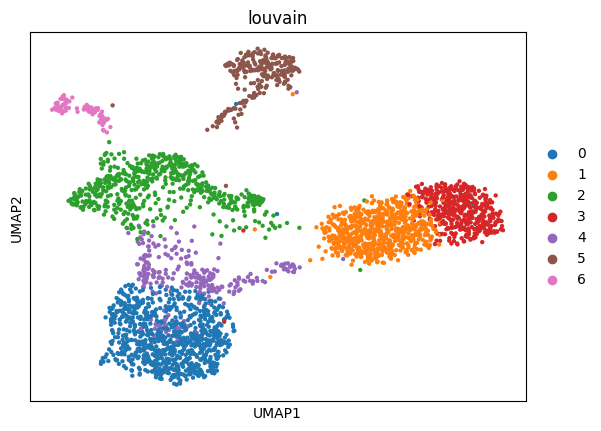

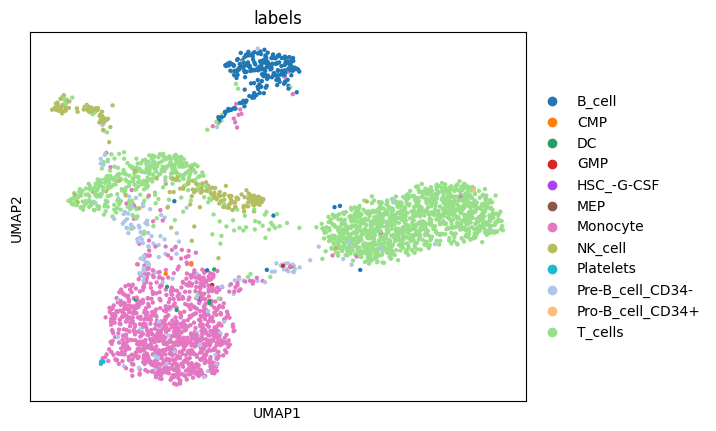

In [27]:
sc.pl.umap(adata1, color='louvain')
sc.pl.umap(adata1, color=label_key)

In [28]:
print(ARI(adata1.obs['louvain'], adata1.obs[label_key]))
print(NMI(adata1.obs['louvain'], adata1.obs[label_key]))
print(cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain'].values.to_numpy()))
print(FMI(adata1.obs['louvain'], adata1.obs[label_key]))
# print(SC(adata1.X, adata1.obs['louvain'].values.reshape(-1, 1)))

0.4455492816972752
0.5615241073478415
0.6018276762402088
0.6078328206420972
